In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


# Data Loading

In [2]:
df_train= pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")
df_sample=pd.read_csv("/kaggle/input/playground-series-s5e12/sample_submission.csv")
print(f"Train set shape : {df_train.shape}")
print(f"Test set shape : {df_test.shape}")


Train set shape : (700000, 26)
Test set shape : (300000, 25)


In [3]:
print(df_train.head(5))

   id  age  alcohol_consumption_per_week  physical_activity_minutes_per_week  \
0   0   31                             1                                  45   
1   1   50                             2                                  73   
2   2   32                             3                                 158   
3   3   54                             3                                  77   
4   4   54                             1                                  55   

   diet_score  sleep_hours_per_day  screen_time_hours_per_day   bmi  \
0         7.7                  6.8                        6.1  33.4   
1         5.7                  6.5                        5.8  23.8   
2         8.5                  7.4                        9.1  24.1   
3         4.6                  7.0                        9.2  26.6   
4         5.7                  6.2                        5.1  28.8   

   waist_to_hip_ratio  systolic_bp  ...  gender  ethnicity  education_level  \
0            

# Exploratory Data Analysis

In [4]:
#Data types and non-null counts
print(df_train.info())

#statistical summary
print(df_train.describe())

#check for duplicates

print(f"\n Duplicated rows: {df_train.describe().sum()}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

Empty DataFrame
Columns: [Column, Missing_count, Missing_Percentage]
Index: []


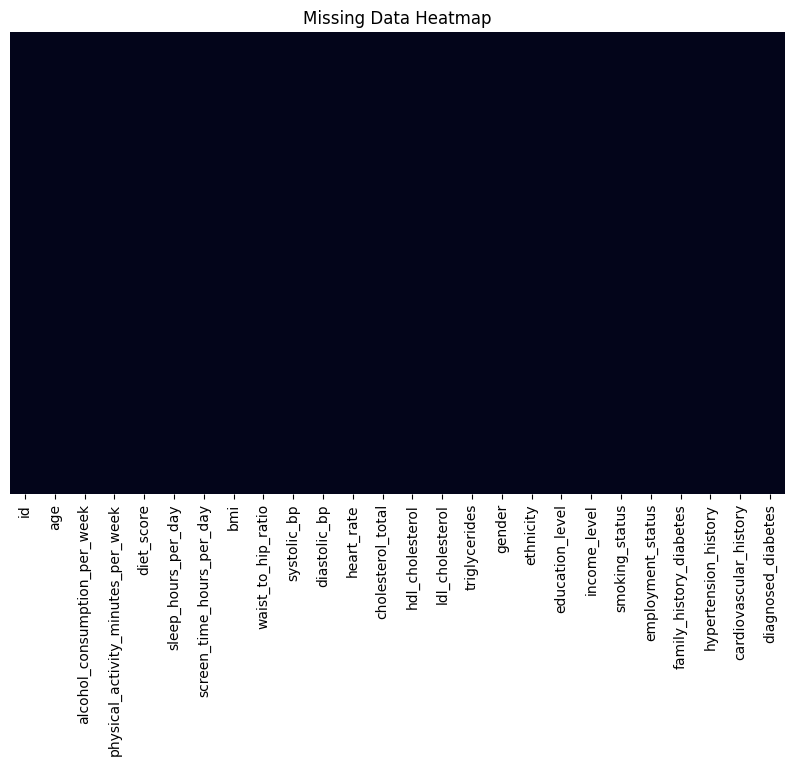

In [5]:
#count missing values

missing=df_train.isnull().sum()
missing_pct=(missing/len(df_train))*1000
missing_df=pd.DataFrame({
    "Column":missing.index,
    "Missing_count": missing.values,
    "Missing_Percentage": missing_pct.values
})

missing_df=missing_df[missing_df["Missing_count"]>0].sort_values("Missing_count",ascending=False)
print(missing_df)

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

diagnosed_diabetes
1.0    436307
0.0    263693
Name: count, dtype: int64


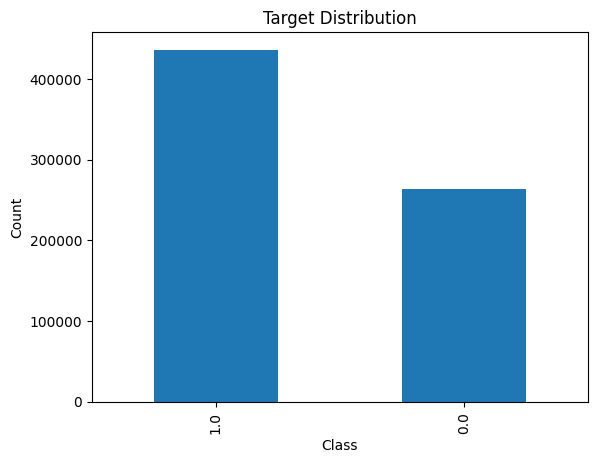

In [6]:
#Target analysis
target_col="diagnosed_diabetes"
print(df_train[target_col].value_counts())
df_train[target_col].value_counts().plot(kind="bar")
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [7]:
#Identify numerical and ctaegorical features
numerical_features = df_train.select_dtypes(include =["int64", "float64"]).columns.tolist()
categorical_features=df_train.select_dtypes(include= ['object']).columns.tolist()

#Remove target from features if present 
if target_col in numerical_features:
    numerical_features.remove(target_col)

print(f"Numerical features: {len(numerical_features)}")
print(f"categorical_features: {len(categorical_features)}")

Numerical features: 19
categorical_features: 6


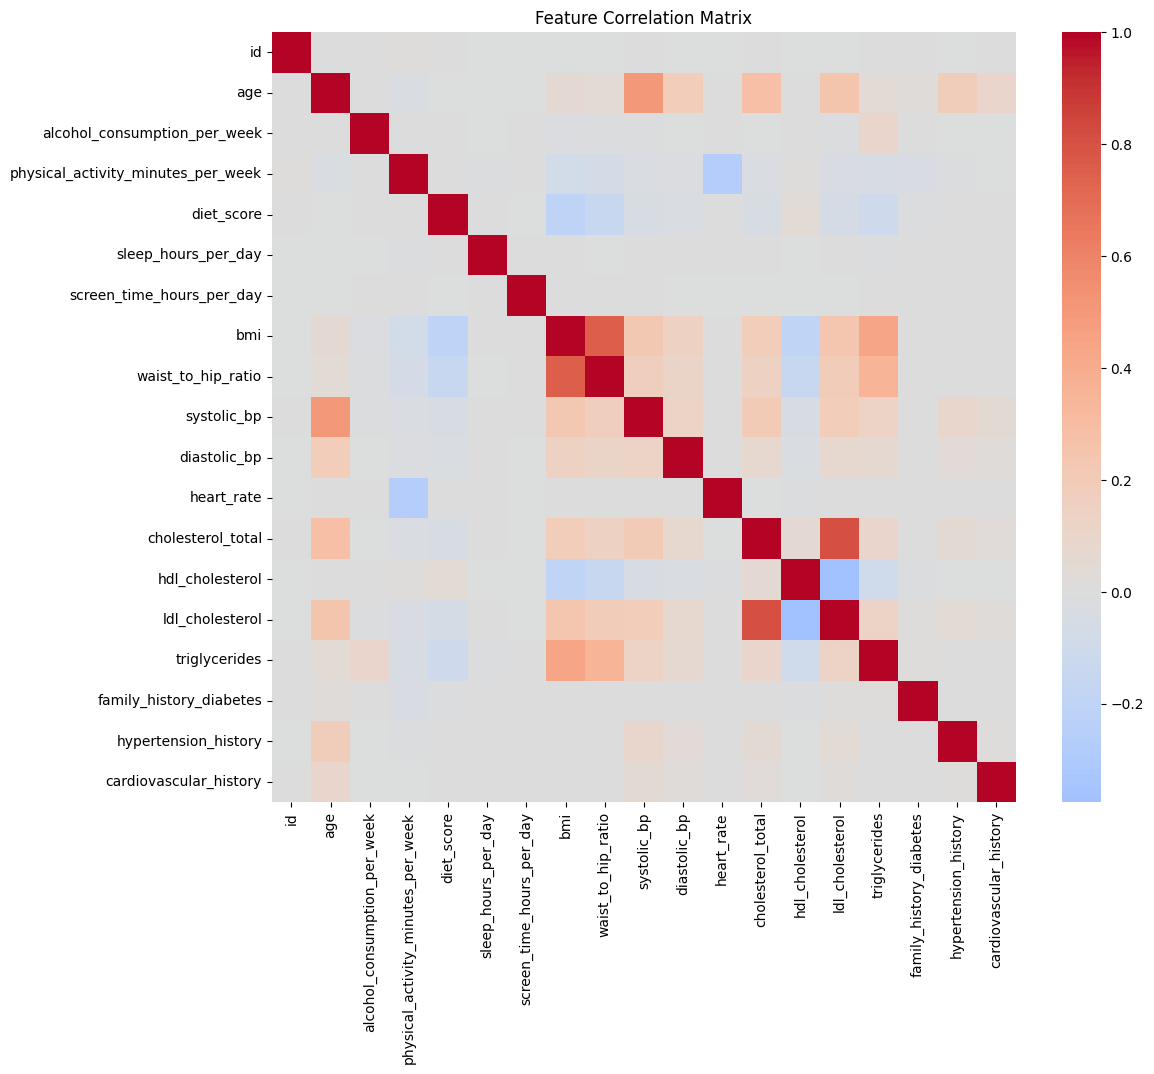


Top correlations with target:
family_history_diabetes    0.211064
age                        0.161162
systolic_bp                0.107132
bmi                        0.105580
ldl_cholesterol            0.102771
triglycerides              0.090635
cholesterol_total          0.088112
waist_to_hip_ratio         0.081050
diastolic_bp               0.036271
hypertension_history       0.029979
Name: diagnosed_diabetes, dtype: float64


In [8]:
#Correlation matrix for numerical features 
correlation = df_train[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Top correlations with target
if target_col in df_train.columns:
    target_corr = df_train[numerical_features + [target_col]].corr()[target_col].sort_values(ascending=False)
    print("\nTop correlations with target:")
    print(target_corr[1:11])


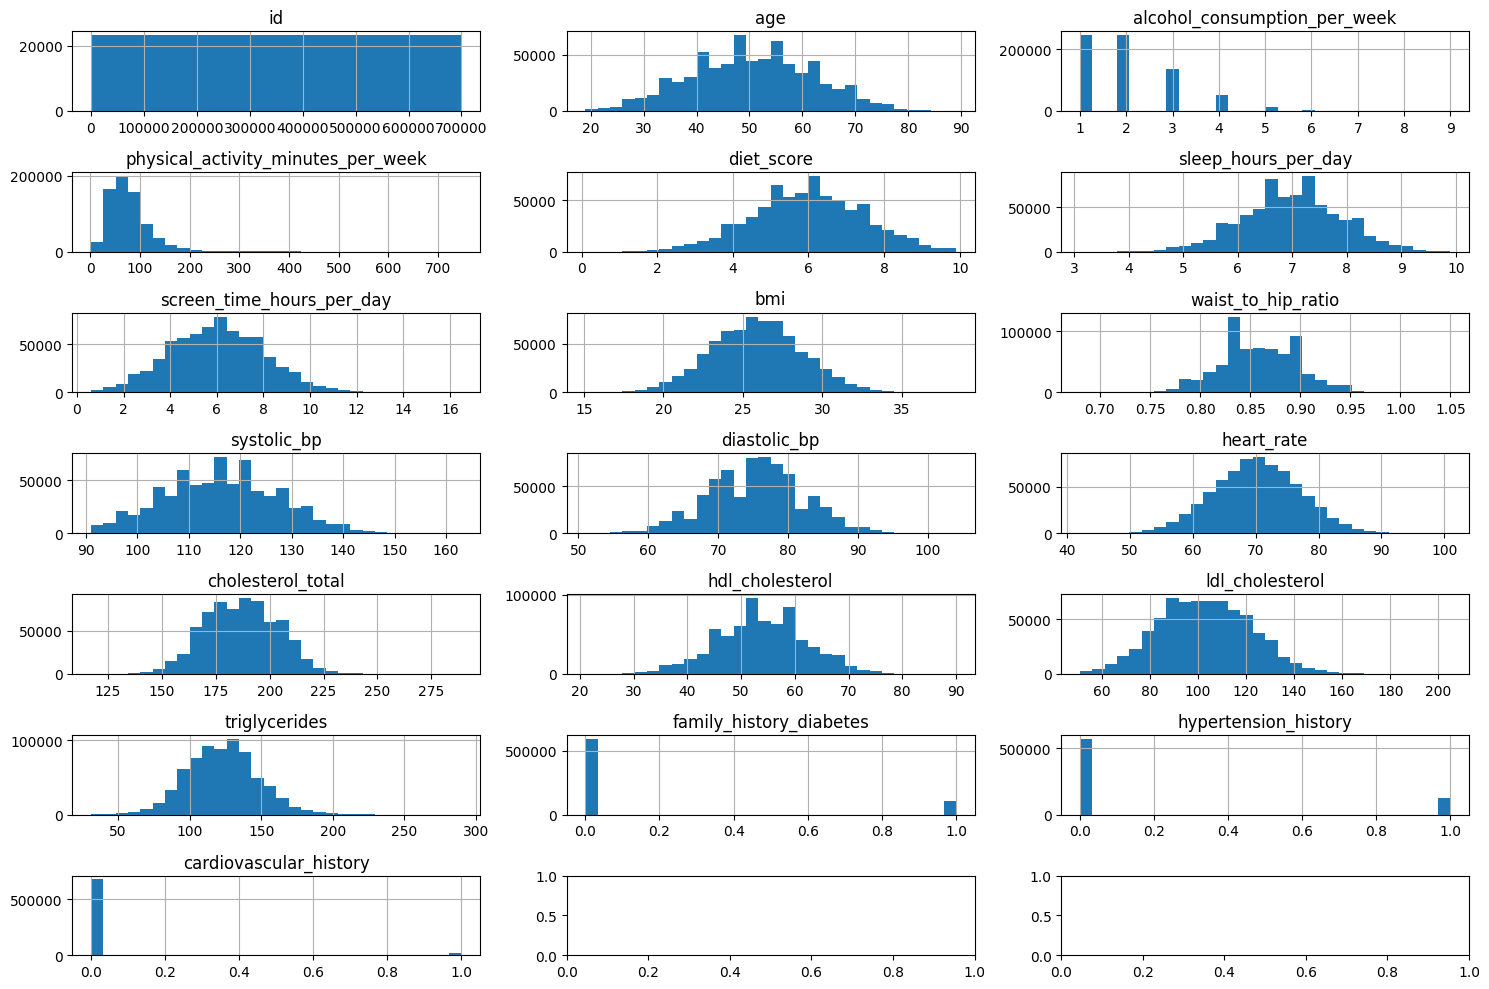

In [9]:
# Plot distributions of numerical features
fig, axes = plt.subplots(nrows=(len(numerical_features)//3)+1, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(numerical_features[:len(axes)]):
    df_train[col].hist(bins=30, ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].set_xlabel('')
    
plt.tight_layout()
plt.show()

# Data Cleaning

In [10]:
#Fill with median for numerical 

for col in numerical_features :
    if df_train[col].isnull().any() :
        median_value = df_train[col].median()
        df_train[col].fillna(median_value, inplace=True)
        df_test[col].fillna(median_value, inplace=True)

#Fill with mode for categorical

for col in categorical_features:
    if df_train[col].isnull().any():
        mode_value=df_train[col].mode()[0]
        df_train[col].fillna(mode_value, inplace=True)
        df_test[col].fillna(mode_value, inplace=True)

# Verify no missing values remain
print(f"Missing values in train: {df_train.isnull().sum().sum()}")
print(f"Missing values in test: {df_test.isnull().sum().sum()}")

Missing values in train: 0
Missing values in test: 0


In [11]:
#Identify outliers usign IQR methods

def remove_outliers(df,columns, threshold=1.5):
    df_clean=df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Feature Engineering

In [12]:
df_train.columns

Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'education_level',
       'income_level', 'smoking_status', 'employment_status',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')

ethnicity
White       386153
Hispanic    129984
Black       106301
Asian        60120
Other        17442
Name: count, dtype: int64


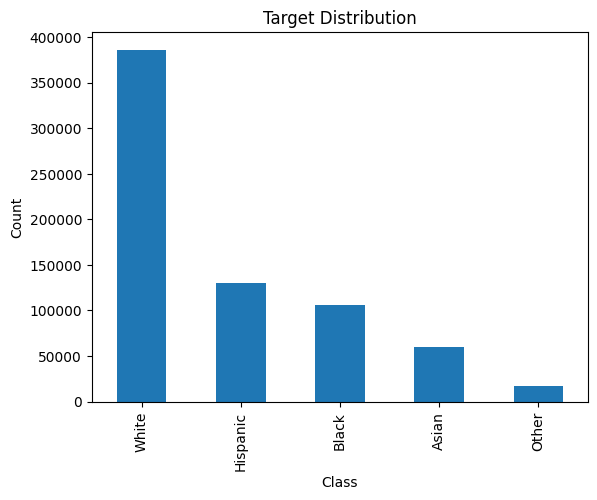

In [13]:
target_col="ethnicity"
print(df_train[target_col].value_counts())
df_train[target_col].value_counts().plot(kind="bar")
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [14]:
# One-hot encoding for multi-class categorical

categorical_for_ohe=[col for col in categorical_features if df_train[col].nunique()>2]
df_train=pd.get_dummies(df_train, columns=categorical_for_ohe, drop_first=True)
df_test=pd.get_dummies(df_test, columns = categorical_for_ohe, drop_first = True)
# Align train and test columns
df_train, df_test = df_train.align(df_test, join='left', axis=1, fill_value=0)

# Feature Selection

In [15]:
#Remove highly correlated features

correlation_matrix=df_train[numerical_features].corr().abs()
upper_triangle=correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool)
)
to_drop=[column for column in upper_triangle.columns if any(upper_triangle[column]>0.95)]
print(f"Features to drop due to high correlation: {to_drop}")

df_train= df_train.drop(columns=to_drop)
df_test=df_test.drop(columns=to_drop)

Features to drop due to high correlation: []


# Train - Test Split

In [16]:
target_col="diagnosed_diabetes"
X=df_train.drop(columns=[target_col,"id"],errors="ignore")
y=df_train[target_col]

X_train,X_val, y_test,y_val= train_test_split(X,y,test_size=0.3, random_state=42,stratify=y)

X_test=df_test[X_train.columns]

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (490000, 36)
Validation set: (210000, 36)
Test set: (300000, 36)


# Feature Selection

In [17]:
from sklearn.preprocessing import StandardScaler


scaler_fs = StandardScaler()
X_train_scaled = scaler_fs.fit_transform(X_train)
X_val_scaled = scaler_fs.transform(X_val)
X_test_scaled = scaler_fs.transform(X_test)
